参考：<a href="https://qiita.com/inoory/items/e63ade6f21766c7c2393">[Python] Keras-RLで簡単に強化学習(DQN)を試す</a>

In [1]:
import gym
import gym.spaces
import numpy as np

# 直線上を動く点の速度を操作し、目標(原点)に移動させることを目標とする環境
class PointOnLine(gym.core.Env):
    def __init__(self):
        self.action_space = gym.spaces.Discrete(3) # 行動空間。速度を下げる、そのまま、上げるの3種

        high = np.array([1.0, 1.0]) # 観測空間(state)の次元 (位置と速度の2次元) とそれらの最大値
        self.observation_space = gym.spaces.Box(low=-high, high=high) # 最小値は、最大値のマイナスがけ

    # 各stepごとに呼ばれる
    # actionを受け取り、次のstateとreward、episodeが終了したかどうかを返すように実装
    def _step(self, action):
        # actionを受け取り、次のstateを決定
        dt = 0.1
        acc = (action - 1) * 0.1
        self._vel += acc * dt
        self._vel = max(-1.0,  min(self._vel, 1.0))
        self._pos += self._vel * dt
        self._pos = max(-1.0,  min(self._pos, 1.0))

        # 位置と速度の絶対値が十分小さくなったらepisode終了
        done = abs(self._pos) < 0.1 and abs(self._vel) < 0.1

        if done:
            # 終了したときに正の報酬
            reward = 1.0
        else:
            # 時間経過ごとに負の報酬
            # ゴールに近づくように、距離が近くなるほど絶対値を減らしておくと、学習が早く進む
            reward = -0.01 * abs(self._pos)

        # 次のstate、reward、終了したかどうか、追加情報の順に返す
        # 追加情報は特にないので空dict
        return np.array([self._pos, self._vel]), reward, done, {}

    # 各episodeの開始時に呼ばれ、初期stateを返すように実装
    def _reset(self):
        # 初期stateは、位置はランダム、速度ゼロ
        self._pos = np.random.rand()*2 - 1
        self._vel = 0.0
        return np.array([self._pos, self._vel])

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

env = PointOnLine()
nb_actions = env.action_space.n

# DQNのネットワーク定義
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

# experience replay用のmemory
memory = SequentialMemory(limit=50000, window_length=1)
# 行動方策はオーソドックスなepsilon-greedy。ほかに、各行動のQ値によって確率を決定するBoltzmannQPolicyが利用可能
policy = EpsGreedyQPolicy(eps=0.1) 
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=100,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

history = dqn.fit(env, nb_steps=50000, visualize=False, verbose=2, nb_max_episode_steps=300)
#学習の様子を描画したいときは、Envに_render()を実装して、visualize=True にします,

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                48        
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_3 (Activation)    (None, 16)                0         
__________

  4861/50000: episode: 24, duration: 0.007s, episode steps: 1, steps per second: 149, episode reward: 1.000, mean reward: 1.000 [1.000, 1.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.020 [0.000, 0.039], loss: 0.000077, mean_absolute_error: 0.176891, mean_q: -0.190569
  4912/50000: episode: 25, duration: 0.235s, episode steps: 51, steps per second: 217, episode reward: 0.728, mean reward: 0.014 [-0.009, 1.000], mean action: 0.824 [0.000, 2.000], mean observation: 0.188 [-0.280, 0.893], loss: 0.000334, mean_absolute_error: 0.190175, mean_q: -0.139767
  4961/50000: episode: 26, duration: 0.244s, episode steps: 49, steps per second: 201, episode reward: 0.783, mean reward: 0.016 [-0.007, 1.000], mean action: 0.816 [0.000, 2.000], mean observation: 0.157 [-0.220, 0.730], loss: 0.000467, mean_absolute_error: 0.187123, mean_q: -0.142160
  5011/50000: episode: 27, duration: 0.239s, episode steps: 50, steps per second: 210, episode reward: 0.757, mean reward: 0.015 [-0.008, 1.00

  6448/50000: episode: 54, duration: 0.127s, episode steps: 44, steps per second: 346, episode reward: 0.874, mean reward: 0.020 [-0.005, 1.000], mean action: 0.818 [0.000, 2.000], mean observation: 0.102 [-0.110, 0.461], loss: 0.000202, mean_absolute_error: 0.272792, mean_q: 0.035074
  6480/50000: episode: 55, duration: 0.134s, episode steps: 32, steps per second: 239, episode reward: 0.942, mean reward: 0.029 [-0.003, 1.000], mean action: 1.219 [0.000, 2.000], mean observation: -0.067 [-0.253, 0.070], loss: 0.000720, mean_absolute_error: 0.275441, mean_q: 0.047237
  6481/50000: episode: 56, duration: 0.008s, episode steps: 1, steps per second: 124, episode reward: 1.000, mean reward: 1.000 [1.000, 1.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.006 [0.000, 0.011], loss: 0.000059, mean_absolute_error: 0.248942, mean_q: -0.003999
  6519/50000: episode: 57, duration: 0.146s, episode steps: 38, steps per second: 260, episode reward: 0.900, mean reward: 0.024 [-0.004, 1.000

  8041/50000: episode: 84, duration: 0.069s, episode steps: 19, steps per second: 275, episode reward: 0.980, mean reward: 0.052 [-0.001, 1.000], mean action: 1.053 [1.000, 2.000], mean observation: -0.049 [-0.117, 0.010], loss: 0.000062, mean_absolute_error: 0.337624, mean_q: 0.229573
  8131/50000: episode: 85, duration: 0.325s, episode steps: 90, steps per second: 277, episode reward: 0.564, mean reward: 0.006 [-0.008, 1.000], mean action: 0.922 [0.000, 2.000], mean observation: 0.204 [-0.140, 0.786], loss: 0.000341, mean_absolute_error: 0.344114, mean_q: 0.231925
  8193/50000: episode: 86, duration: 0.217s, episode steps: 62, steps per second: 286, episode reward: 0.703, mean reward: 0.011 [-0.008, 1.000], mean action: 1.145 [0.000, 2.000], mean observation: -0.181 [-0.839, 0.160], loss: 0.000129, mean_absolute_error: 0.345212, mean_q: 0.227804
  8242/50000: episode: 87, duration: 0.160s, episode steps: 49, steps per second: 306, episode reward: 0.905, mean reward: 0.018 [-0.003, 1.

  9558/50000: episode: 114, duration: 0.203s, episode steps: 57, steps per second: 281, episode reward: 0.707, mean reward: 0.012 [-0.009, 1.000], mean action: 1.105 [0.000, 2.000], mean observation: -0.188 [-0.882, 0.220], loss: 0.000172, mean_absolute_error: 0.371738, mean_q: 0.387300
  9559/50000: episode: 115, duration: 0.010s, episode steps: 1, steps per second: 104, episode reward: 1.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.040 [-0.010, 0.091], loss: 0.000235, mean_absolute_error: 0.373245, mean_q: 0.453195
  9560/50000: episode: 116, duration: 0.010s, episode steps: 1, steps per second: 100, episode reward: 1.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.033 [-0.010, 0.076], loss: 0.000079, mean_absolute_error: 0.347057, mean_q: 0.384288
  9589/50000: episode: 117, duration: 0.093s, episode steps: 29, steps per second: 313, episode reward: 0.938, mean reward: 0.032 [-0.003, 1.0

 10653/50000: episode: 143, duration: 0.078s, episode steps: 19, steps per second: 243, episode reward: 0.974, mean reward: 0.051 [-0.002, 1.000], mean action: 1.474 [0.000, 2.000], mean observation: -0.032 [-0.202, 0.130], loss: 0.000083, mean_absolute_error: 0.385346, mean_q: 0.522254
 10694/50000: episode: 144, duration: 0.194s, episode steps: 41, steps per second: 211, episode reward: 0.873, mean reward: 0.021 [-0.005, 1.000], mean action: 0.780 [0.000, 2.000], mean observation: 0.090 [-0.220, 0.539], loss: 0.000112, mean_absolute_error: 0.379351, mean_q: 0.517121
 10704/50000: episode: 145, duration: 0.116s, episode steps: 10, steps per second: 86, episode reward: 0.990, mean reward: 0.099 [-0.001, 1.000], mean action: 0.800 [0.000, 1.000], mean observation: 0.045 [-0.020, 0.115], loss: 0.000059, mean_absolute_error: 0.387682, mean_q: 0.528012
 10720/50000: episode: 146, duration: 0.060s, episode steps: 16, steps per second: 266, episode reward: 0.978, mean reward: 0.061 [-0.002, 

 11687/50000: episode: 173, duration: 0.247s, episode steps: 65, steps per second: 263, episode reward: 0.768, mean reward: 0.012 [-0.007, 1.000], mean action: 1.062 [0.000, 2.000], mean observation: -0.135 [-0.678, 0.160], loss: 0.000059, mean_absolute_error: 0.385198, mean_q: 0.576524
 11746/50000: episode: 174, duration: 0.177s, episode steps: 59, steps per second: 333, episode reward: 0.865, mean reward: 0.015 [-0.005, 1.000], mean action: 1.034 [0.000, 2.000], mean observation: -0.084 [-0.458, 0.140], loss: 0.000078, mean_absolute_error: 0.390565, mean_q: 0.586045
 11835/50000: episode: 175, duration: 0.281s, episode steps: 89, steps per second: 317, episode reward: 0.748, mean reward: 0.008 [-0.007, 1.000], mean action: 1.034 [0.000, 2.000], mean observation: -0.109 [-0.679, 0.180], loss: 0.000052, mean_absolute_error: 0.391531, mean_q: 0.587685
 11848/50000: episode: 176, duration: 0.040s, episode steps: 13, steps per second: 325, episode reward: 0.985, mean reward: 0.076 [-0.00

 12870/50000: episode: 203, duration: 0.208s, episode steps: 44, steps per second: 212, episode reward: 0.846, mean reward: 0.019 [-0.006, 1.000], mean action: 0.795 [0.000, 2.000], mean observation: 0.115 [-0.200, 0.593], loss: 0.000075, mean_absolute_error: 0.405757, mean_q: 0.613817
 12923/50000: episode: 204, duration: 0.223s, episode steps: 53, steps per second: 238, episode reward: 0.876, mean reward: 0.017 [-0.005, 1.000], mean action: 1.057 [0.000, 2.000], mean observation: -0.084 [-0.456, 0.150], loss: 0.000033, mean_absolute_error: 0.402594, mean_q: 0.609841
 13002/50000: episode: 205, duration: 0.457s, episode steps: 79, steps per second: 173, episode reward: 0.718, mean reward: 0.009 [-0.008, 1.000], mean action: 1.013 [0.000, 2.000], mean observation: -0.135 [-0.789, 0.180], loss: 0.000064, mean_absolute_error: 0.404756, mean_q: 0.612915
 13003/50000: episode: 206, duration: 0.008s, episode steps: 1, steps per second: 123, episode reward: 1.000, mean reward: 1.000 [1.000, 

 13998/50000: episode: 233, duration: 0.196s, episode steps: 53, steps per second: 271, episode reward: 0.802, mean reward: 0.015 [-0.007, 1.000], mean action: 1.113 [0.000, 2.000], mean observation: -0.135 [-0.665, 0.170], loss: 0.000031, mean_absolute_error: 0.409642, mean_q: 0.621026
 13999/50000: episode: 234, duration: 0.007s, episode steps: 1, steps per second: 138, episode reward: 1.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.015 [0.010, 0.020], loss: 0.000025, mean_absolute_error: 0.436329, mean_q: 0.661216
 14043/50000: episode: 235, duration: 0.144s, episode steps: 44, steps per second: 305, episode reward: 0.889, mean reward: 0.020 [-0.004, 1.000], mean action: 1.068 [0.000, 2.000], mean observation: -0.089 [-0.435, 0.140], loss: 0.000035, mean_absolute_error: 0.403224, mean_q: 0.611042
 14101/50000: episode: 236, duration: 0.185s, episode steps: 58, steps per second: 313, episode reward: 0.764, mean reward: 0.013 [-0.008, 1

 15266/50000: episode: 262, duration: 0.300s, episode steps: 39, steps per second: 130, episode reward: 0.887, mean reward: 0.023 [-0.005, 1.000], mean action: 1.205 [0.000, 2.000], mean observation: -0.096 [-0.479, 0.160], loss: 0.000031, mean_absolute_error: 0.416523, mean_q: 0.630079
 15302/50000: episode: 263, duration: 0.272s, episode steps: 36, steps per second: 132, episode reward: 0.900, mean reward: 0.025 [-0.004, 1.000], mean action: 1.250 [0.000, 2.000], mean observation: -0.092 [-0.439, 0.150], loss: 0.000029, mean_absolute_error: 0.416446, mean_q: 0.630687
 15362/50000: episode: 264, duration: 0.312s, episode steps: 60, steps per second: 192, episode reward: 0.731, mean reward: 0.012 [-0.008, 1.000], mean action: 1.117 [0.000, 2.000], mean observation: -0.167 [-0.788, 0.180], loss: 0.000068, mean_absolute_error: 0.423806, mean_q: 0.640426
 15406/50000: episode: 265, duration: 0.210s, episode steps: 44, steps per second: 210, episode reward: 0.823, mean reward: 0.019 [-0.00

 16415/50000: episode: 293, duration: 0.527s, episode steps: 52, steps per second: 99, episode reward: 0.787, mean reward: 0.015 [-0.007, 1.000], mean action: 1.173 [0.000, 2.000], mean observation: -0.147 [-0.706, 0.190], loss: 0.000030, mean_absolute_error: 0.421795, mean_q: 0.635572
 16416/50000: episode: 294, duration: 0.051s, episode steps: 1, steps per second: 20, episode reward: 1.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [2.000, 2.000], mean observation: -0.011 [-0.032, 0.010], loss: 0.000070, mean_absolute_error: 0.396817, mean_q: 0.586562
 16481/50000: episode: 295, duration: 0.411s, episode steps: 65, steps per second: 158, episode reward: 0.673, mean reward: 0.010 [-0.009, 1.000], mean action: 1.108 [0.000, 2.000], mean observation: -0.189 [-0.911, 0.230], loss: 0.000047, mean_absolute_error: 0.421730, mean_q: 0.635499
 16530/50000: episode: 296, duration: 0.255s, episode steps: 49, steps per second: 192, episode reward: 0.821, mean reward: 0.017 [-0.006, 1

 17499/50000: episode: 323, duration: 0.163s, episode steps: 45, steps per second: 276, episode reward: 0.842, mean reward: 0.019 [-0.006, 1.000], mean action: 1.178 [0.000, 2.000], mean observation: -0.121 [-0.595, 0.180], loss: 0.000053, mean_absolute_error: 0.419439, mean_q: 0.629358
 17500/50000: episode: 324, duration: 0.007s, episode steps: 1, steps per second: 148, episode reward: 1.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [2.000, 2.000], mean observation: -0.044 [-0.098, 0.010], loss: 0.000035, mean_absolute_error: 0.345216, mean_q: 0.507321
 17544/50000: episode: 325, duration: 0.126s, episode steps: 44, steps per second: 348, episode reward: 0.798, mean reward: 0.018 [-0.007, 1.000], mean action: 0.795 [0.000, 2.000], mean observation: 0.157 [-0.260, 0.745], loss: 0.000034, mean_absolute_error: 0.420431, mean_q: 0.631164
 17613/50000: episode: 326, duration: 0.202s, episode steps: 69, steps per second: 342, episode reward: 0.618, mean reward: 0.009 [-0.010, 

 18405/50000: episode: 353, duration: 0.216s, episode steps: 62, steps per second: 287, episode reward: 0.684, mean reward: 0.011 [-0.010, 1.000], mean action: 1.129 [0.000, 2.000], mean observation: -0.186 [-0.953, 0.250], loss: 0.000025, mean_absolute_error: 0.427919, mean_q: 0.637190
 18414/50000: episode: 354, duration: 0.032s, episode steps: 9, steps per second: 279, episode reward: 0.990, mean reward: 0.110 [-0.001, 1.000], mean action: 2.000 [2.000, 2.000], mean observation: -0.035 [-0.136, 0.090], loss: 0.000017, mean_absolute_error: 0.452925, mean_q: 0.678207
 18452/50000: episode: 355, duration: 0.112s, episode steps: 38, steps per second: 339, episode reward: 0.879, mean reward: 0.023 [-0.005, 1.000], mean action: 0.763 [0.000, 2.000], mean observation: 0.107 [-0.190, 0.488], loss: 0.000028, mean_absolute_error: 0.428303, mean_q: 0.638405
 18498/50000: episode: 356, duration: 0.139s, episode steps: 46, steps per second: 332, episode reward: 0.847, mean reward: 0.018 [-0.005,

 19605/50000: episode: 382, duration: 0.204s, episode steps: 45, steps per second: 221, episode reward: 0.850, mean reward: 0.019 [-0.005, 1.000], mean action: 1.200 [0.000, 2.000], mean observation: -0.118 [-0.537, 0.150], loss: 0.000027, mean_absolute_error: 0.430354, mean_q: 0.633632
 19635/50000: episode: 383, duration: 0.101s, episode steps: 30, steps per second: 296, episode reward: 0.933, mean reward: 0.031 [-0.003, 1.000], mean action: 1.233 [0.000, 2.000], mean observation: -0.071 [-0.342, 0.120], loss: 0.000020, mean_absolute_error: 0.435960, mean_q: 0.643387
 19636/50000: episode: 384, duration: 0.007s, episode steps: 1, steps per second: 148, episode reward: 1.000, mean reward: 1.000 [1.000, 1.000], mean action: 1.000 [1.000, 1.000], mean observation: -0.010 [-0.020, 0.000], loss: 0.000021, mean_absolute_error: 0.398980, mean_q: 0.590033
 19696/50000: episode: 385, duration: 0.176s, episode steps: 60, steps per second: 342, episode reward: 0.737, mean reward: 0.012 [-0.008,

 20829/50000: episode: 412, duration: 0.006s, episode steps: 1, steps per second: 154, episode reward: 1.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.013 [-0.010, 0.037], loss: 0.000013, mean_absolute_error: 0.450564, mean_q: 0.681333
 20876/50000: episode: 413, duration: 0.138s, episode steps: 47, steps per second: 341, episode reward: 0.799, mean reward: 0.017 [-0.007, 1.000], mean action: 0.809 [0.000, 2.000], mean observation: 0.147 [-0.210, 0.727], loss: 0.000018, mean_absolute_error: 0.440070, mean_q: 0.648474
 20877/50000: episode: 414, duration: 0.007s, episode steps: 1, steps per second: 153, episode reward: 1.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [2.000, 2.000], mean observation: -0.012 [-0.034, 0.010], loss: 0.000010, mean_absolute_error: 0.375375, mean_q: 0.538777
 20878/50000: episode: 415, duration: 0.007s, episode steps: 1, steps per second: 149, episode reward: 1.000, mean reward: 1.000 [1.000, 1.000

 21855/50000: episode: 442, duration: 0.180s, episode steps: 53, steps per second: 294, episode reward: 0.752, mean reward: 0.014 [-0.008, 1.000], mean action: 0.830 [0.000, 2.000], mean observation: 0.166 [-0.220, 0.821], loss: 0.000018, mean_absolute_error: 0.442154, mean_q: 0.654444
 21870/50000: episode: 443, duration: 0.065s, episode steps: 15, steps per second: 231, episode reward: 0.978, mean reward: 0.065 [-0.002, 1.000], mean action: 1.533 [0.000, 2.000], mean observation: -0.043 [-0.196, 0.110], loss: 0.000020, mean_absolute_error: 0.444328, mean_q: 0.658600
 21914/50000: episode: 444, duration: 0.162s, episode steps: 44, steps per second: 271, episode reward: 0.831, mean reward: 0.019 [-0.006, 1.000], mean action: 1.205 [0.000, 2.000], mean observation: -0.130 [-0.647, 0.200], loss: 0.000024, mean_absolute_error: 0.443442, mean_q: 0.655934
 21954/50000: episode: 445, duration: 0.184s, episode steps: 40, steps per second: 217, episode reward: 0.880, mean reward: 0.022 [-0.005

 22873/50000: episode: 472, duration: 0.133s, episode steps: 42, steps per second: 315, episode reward: 0.857, mean reward: 0.020 [-0.006, 1.000], mean action: 0.857 [0.000, 2.000], mean observation: 0.116 [-0.190, 0.560], loss: 0.000014, mean_absolute_error: 0.451528, mean_q: 0.670682
 22935/50000: episode: 473, duration: 0.224s, episode steps: 62, steps per second: 277, episode reward: 0.647, mean reward: 0.010 [-0.010, 1.000], mean action: 1.113 [0.000, 2.000], mean observation: -0.213 [-0.998, 0.220], loss: 0.000030, mean_absolute_error: 0.442414, mean_q: 0.657003
 22959/50000: episode: 474, duration: 0.081s, episode steps: 24, steps per second: 298, episode reward: 0.952, mean reward: 0.040 [-0.003, 1.000], mean action: 1.375 [0.000, 2.000], mean observation: -0.063 [-0.284, 0.130], loss: 0.000027, mean_absolute_error: 0.454670, mean_q: 0.679845
 23018/50000: episode: 475, duration: 0.195s, episode steps: 59, steps per second: 302, episode reward: 0.664, mean reward: 0.011 [-0.010

 24035/50000: episode: 502, duration: 0.056s, episode steps: 17, steps per second: 306, episode reward: 0.974, mean reward: 0.057 [-0.002, 1.000], mean action: 1.412 [0.000, 2.000], mean observation: -0.046 [-0.200, 0.090], loss: 0.000032, mean_absolute_error: 0.449253, mean_q: 0.673989
 24055/50000: episode: 503, duration: 0.061s, episode steps: 20, steps per second: 325, episode reward: 0.966, mean reward: 0.048 [-0.002, 1.000], mean action: 1.400 [0.000, 2.000], mean observation: -0.052 [-0.239, 0.110], loss: 0.000140, mean_absolute_error: 0.466475, mean_q: 0.698592
 24095/50000: episode: 504, duration: 0.113s, episode steps: 40, steps per second: 354, episode reward: 0.892, mean reward: 0.022 [-0.005, 1.000], mean action: 0.875 [0.000, 2.000], mean observation: 0.092 [-0.160, 0.452], loss: 0.000024, mean_absolute_error: 0.448417, mean_q: 0.670833
 24157/50000: episode: 505, duration: 0.179s, episode steps: 62, steps per second: 347, episode reward: 0.657, mean reward: 0.011 [-0.010

 25034/50000: episode: 531, duration: 0.161s, episode steps: 40, steps per second: 248, episode reward: 0.899, mean reward: 0.022 [-0.004, 1.000], mean action: 0.850 [0.000, 2.000], mean observation: 0.088 [-0.150, 0.405], loss: 0.000023, mean_absolute_error: 0.457289, mean_q: 0.686705
 25059/50000: episode: 532, duration: 0.085s, episode steps: 25, steps per second: 296, episode reward: 0.951, mean reward: 0.038 [-0.003, 1.000], mean action: 1.280 [0.000, 2.000], mean observation: -0.063 [-0.281, 0.120], loss: 0.000029, mean_absolute_error: 0.447046, mean_q: 0.670451
 25115/50000: episode: 533, duration: 0.195s, episode steps: 56, steps per second: 287, episode reward: 0.747, mean reward: 0.013 [-0.008, 1.000], mean action: 1.161 [0.000, 2.000], mean observation: -0.163 [-0.808, 0.230], loss: 0.000023, mean_absolute_error: 0.458552, mean_q: 0.689352
 25159/50000: episode: 534, duration: 0.128s, episode steps: 44, steps per second: 344, episode reward: 0.864, mean reward: 0.020 [-0.005

 26041/50000: episode: 560, duration: 0.231s, episode steps: 51, steps per second: 221, episode reward: 0.796, mean reward: 0.016 [-0.007, 1.000], mean action: 1.157 [0.000, 2.000], mean observation: -0.142 [-0.692, 0.180], loss: 0.000025, mean_absolute_error: 0.457132, mean_q: 0.688566
 26060/50000: episode: 561, duration: 0.168s, episode steps: 19, steps per second: 113, episode reward: 0.971, mean reward: 0.051 [-0.002, 1.000], mean action: 1.368 [0.000, 2.000], mean observation: -0.049 [-0.212, 0.080], loss: 0.000033, mean_absolute_error: 0.458083, mean_q: 0.687429
 26100/50000: episode: 562, duration: 0.223s, episode steps: 40, steps per second: 180, episode reward: 0.884, mean reward: 0.022 [-0.005, 1.000], mean action: 0.950 [0.000, 2.000], mean observation: 0.096 [-0.170, 0.497], loss: 0.000025, mean_absolute_error: 0.458831, mean_q: 0.691639
 26141/50000: episode: 563, duration: 0.176s, episode steps: 41, steps per second: 232, episode reward: 0.875, mean reward: 0.021 [-0.005

 27497/50000: episode: 591, duration: 0.091s, episode steps: 29, steps per second: 318, episode reward: 0.927, mean reward: 0.032 [-0.004, 1.000], mean action: 0.690 [0.000, 2.000], mean observation: 0.078 [-0.140, 0.384], loss: 0.000030, mean_absolute_error: 0.451593, mean_q: 0.681044
 27529/50000: episode: 592, duration: 0.097s, episode steps: 32, steps per second: 332, episode reward: 0.910, mean reward: 0.028 [-0.004, 1.000], mean action: 1.281 [0.000, 2.000], mean observation: -0.092 [-0.414, 0.180], loss: 0.000039, mean_absolute_error: 0.452945, mean_q: 0.682811
 27582/50000: episode: 593, duration: 0.188s, episode steps: 53, steps per second: 282, episode reward: 0.762, mean reward: 0.014 [-0.008, 1.000], mean action: 0.830 [0.000, 2.000], mean observation: 0.153 [-0.230, 0.795], loss: 0.000048, mean_absolute_error: 0.454606, mean_q: 0.684420
 27617/50000: episode: 594, duration: 0.142s, episode steps: 35, steps per second: 246, episode reward: 0.893, mean reward: 0.026 [-0.005,

 28608/50000: episode: 620, duration: 0.238s, episode steps: 54, steps per second: 227, episode reward: 0.729, mean reward: 0.013 [-0.008, 1.000], mean action: 1.167 [0.000, 2.000], mean observation: -0.180 [-0.842, 0.230], loss: 0.000058, mean_absolute_error: 0.452772, mean_q: 0.682891
 28694/50000: episode: 621, duration: 0.458s, episode steps: 86, steps per second: 188, episode reward: 0.706, mean reward: 0.008 [-0.008, 1.000], mean action: 1.105 [0.000, 2.000], mean observation: 0.040 [-0.320, 0.847], loss: 0.000049, mean_absolute_error: 0.458233, mean_q: 0.691100
 28718/50000: episode: 622, duration: 0.162s, episode steps: 24, steps per second: 148, episode reward: 0.962, mean reward: 0.040 [-0.002, 1.000], mean action: 1.125 [0.000, 2.000], mean observation: -0.053 [-0.233, 0.110], loss: 0.000047, mean_absolute_error: 0.456522, mean_q: 0.687664
 28758/50000: episode: 623, duration: 0.315s, episode steps: 40, steps per second: 127, episode reward: 0.919, mean reward: 0.023 [-0.003

 29622/50000: episode: 649, duration: 0.385s, episode steps: 53, steps per second: 138, episode reward: 0.713, mean reward: 0.013 [-0.009, 1.000], mean action: 0.868 [0.000, 2.000], mean observation: 0.196 [-0.260, 0.899], loss: 0.000038, mean_absolute_error: 0.461609, mean_q: 0.696939
 29623/50000: episode: 650, duration: 0.009s, episode steps: 1, steps per second: 112, episode reward: 1.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.010 [-0.010, 0.029], loss: 0.000018, mean_absolute_error: 0.414149, mean_q: 0.624766
 29650/50000: episode: 651, duration: 0.210s, episode steps: 27, steps per second: 129, episode reward: 0.944, mean reward: 0.035 [-0.003, 1.000], mean action: 1.222 [0.000, 2.000], mean observation: -0.066 [-0.315, 0.130], loss: 0.000033, mean_absolute_error: 0.463840, mean_q: 0.700178
 29725/50000: episode: 652, duration: 0.412s, episode steps: 75, steps per second: 182, episode reward: 0.637, mean reward: 0.008 [-0.010, 1

 30885/50000: episode: 678, duration: 0.237s, episode steps: 44, steps per second: 185, episode reward: 0.824, mean reward: 0.019 [-0.007, 1.000], mean action: 1.205 [0.000, 2.000], mean observation: -0.136 [-0.662, 0.210], loss: 0.000034, mean_absolute_error: 0.465890, mean_q: 0.703449
 30931/50000: episode: 679, duration: 0.224s, episode steps: 46, steps per second: 205, episode reward: 0.810, mean reward: 0.018 [-0.007, 1.000], mean action: 1.130 [0.000, 2.000], mean observation: -0.142 [-0.707, 0.230], loss: 0.000061, mean_absolute_error: 0.471648, mean_q: 0.712622
 30985/50000: episode: 680, duration: 0.288s, episode steps: 54, steps per second: 187, episode reward: 0.697, mean reward: 0.013 [-0.010, 1.000], mean action: 1.167 [0.000, 2.000], mean observation: -0.200 [-0.966, 0.270], loss: 0.000059, mean_absolute_error: 0.460383, mean_q: 0.694721
 31041/50000: episode: 681, duration: 0.244s, episode steps: 56, steps per second: 230, episode reward: 0.719, mean reward: 0.013 [-0.00

 31808/50000: episode: 707, duration: 0.169s, episode steps: 56, steps per second: 332, episode reward: 0.676, mean reward: 0.012 [-0.010, 1.000], mean action: 1.161 [0.000, 2.000], mean observation: -0.213 [-0.971, 0.280], loss: 0.000026, mean_absolute_error: 0.469702, mean_q: 0.708771
 31863/50000: episode: 708, duration: 0.186s, episode steps: 55, steps per second: 295, episode reward: 0.694, mean reward: 0.013 [-0.010, 1.000], mean action: 1.109 [0.000, 2.000], mean observation: -0.200 [-0.964, 0.270], loss: 0.000030, mean_absolute_error: 0.470820, mean_q: 0.709762
 31919/50000: episode: 709, duration: 0.165s, episode steps: 56, steps per second: 339, episode reward: 0.700, mean reward: 0.012 [-0.009, 1.000], mean action: 1.161 [0.000, 2.000], mean observation: -0.193 [-0.948, 0.260], loss: 0.000036, mean_absolute_error: 0.463240, mean_q: 0.698540
 31981/50000: episode: 710, duration: 0.229s, episode steps: 62, steps per second: 271, episode reward: 0.677, mean reward: 0.011 [-0.01

 32815/50000: episode: 736, duration: 0.146s, episode steps: 50, steps per second: 343, episode reward: 0.824, mean reward: 0.016 [-0.006, 1.000], mean action: 0.860 [0.000, 2.000], mean observation: 0.127 [-0.140, 0.595], loss: 0.000023, mean_absolute_error: 0.472303, mean_q: 0.710819
 32841/50000: episode: 737, duration: 0.089s, episode steps: 26, steps per second: 293, episode reward: 0.942, mean reward: 0.036 [-0.003, 1.000], mean action: 1.308 [0.000, 2.000], mean observation: -0.069 [-0.331, 0.140], loss: 0.000040, mean_absolute_error: 0.473586, mean_q: 0.711831
 32883/50000: episode: 738, duration: 0.128s, episode steps: 42, steps per second: 329, episode reward: 0.862, mean reward: 0.021 [-0.005, 1.000], mean action: 1.119 [0.000, 2.000], mean observation: -0.117 [-0.507, 0.170], loss: 0.000046, mean_absolute_error: 0.471389, mean_q: 0.709296
 32898/50000: episode: 739, duration: 0.051s, episode steps: 15, steps per second: 292, episode reward: 0.978, mean reward: 0.065 [-0.002

 34004/50000: episode: 766, duration: 0.008s, episode steps: 1, steps per second: 119, episode reward: 1.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: -0.020 [-0.029, -0.010], loss: 0.000091, mean_absolute_error: 0.486853, mean_q: 0.730320
 34057/50000: episode: 767, duration: 0.201s, episode steps: 53, steps per second: 263, episode reward: 0.734, mean reward: 0.014 [-0.009, 1.000], mean action: 1.151 [0.000, 2.000], mean observation: -0.179 [-0.862, 0.220], loss: 0.000042, mean_absolute_error: 0.466578, mean_q: 0.698871
 34058/50000: episode: 768, duration: 0.007s, episode steps: 1, steps per second: 138, episode reward: 1.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.039 [-0.010, 0.089], loss: 0.000026, mean_absolute_error: 0.496890, mean_q: 0.741557
 34086/50000: episode: 769, duration: 0.085s, episode steps: 28, steps per second: 328, episode reward: 0.934, mean reward: 0.033 [-0.004, 1

 35169/50000: episode: 796, duration: 0.192s, episode steps: 51, steps per second: 266, episode reward: 0.852, mean reward: 0.017 [-0.006, 1.000], mean action: 0.824 [0.000, 2.000], mean observation: 0.092 [-0.170, 0.555], loss: 0.000032, mean_absolute_error: 0.466850, mean_q: 0.696939
 35170/50000: episode: 797, duration: 0.007s, episode steps: 1, steps per second: 152, episode reward: 1.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.002 [-0.010, 0.014], loss: 0.000021, mean_absolute_error: 0.467095, mean_q: 0.699245
 35220/50000: episode: 798, duration: 0.333s, episode steps: 50, steps per second: 150, episode reward: 0.845, mean reward: 0.017 [-0.005, 1.000], mean action: 0.840 [0.000, 2.000], mean observation: 0.112 [-0.160, 0.531], loss: 0.000046, mean_absolute_error: 0.456985, mean_q: 0.679548
 35221/50000: episode: 799, duration: 0.007s, episode steps: 1, steps per second: 135, episode reward: 1.000, mean reward: 1.000 [1.000, 1.00

 36220/50000: episode: 825, duration: 0.143s, episode steps: 48, steps per second: 335, episode reward: 0.797, mean reward: 0.017 [-0.007, 1.000], mean action: 1.146 [0.000, 2.000], mean observation: -0.149 [-0.702, 0.230], loss: 0.000029, mean_absolute_error: 0.468684, mean_q: 0.697370
 36258/50000: episode: 826, duration: 0.111s, episode steps: 38, steps per second: 341, episode reward: 0.909, mean reward: 0.024 [-0.004, 1.000], mean action: 0.763 [0.000, 2.000], mean observation: 0.079 [-0.130, 0.380], loss: 0.000037, mean_absolute_error: 0.465095, mean_q: 0.694086
 36259/50000: episode: 827, duration: 0.006s, episode steps: 1, steps per second: 175, episode reward: 1.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.035 [-0.010, 0.080], loss: 0.000034, mean_absolute_error: 0.439014, mean_q: 0.646546
 36317/50000: episode: 828, duration: 0.202s, episode steps: 58, steps per second: 288, episode reward: 0.767, mean reward: 0.013 [-0.007, 1

 37281/50000: episode: 856, duration: 0.156s, episode steps: 53, steps per second: 340, episode reward: 0.832, mean reward: 0.016 [-0.006, 1.000], mean action: 0.830 [0.000, 2.000], mean observation: 0.105 [-0.180, 0.595], loss: 0.000077, mean_absolute_error: 0.472438, mean_q: 0.703632
 37308/50000: episode: 857, duration: 0.081s, episode steps: 27, steps per second: 334, episode reward: 0.973, mean reward: 0.036 [-0.002, 1.000], mean action: 0.667 [0.000, 2.000], mean observation: 0.008 [-0.110, 0.186], loss: 0.000045, mean_absolute_error: 0.460330, mean_q: 0.681747
 37334/50000: episode: 858, duration: 0.077s, episode steps: 26, steps per second: 336, episode reward: 0.963, mean reward: 0.037 [-0.002, 1.000], mean action: 1.077 [0.000, 2.000], mean observation: -0.052 [-0.214, 0.090], loss: 0.000025, mean_absolute_error: 0.466137, mean_q: 0.693085
 37355/50000: episode: 859, duration: 0.069s, episode steps: 21, steps per second: 306, episode reward: 0.969, mean reward: 0.046 [-0.002,

 38444/50000: episode: 885, duration: 0.056s, episode steps: 16, steps per second: 285, episode reward: 0.977, mean reward: 0.061 [-0.002, 1.000], mean action: 1.562 [0.000, 2.000], mean observation: -0.046 [-0.177, 0.100], loss: 0.000039, mean_absolute_error: 0.473110, mean_q: 0.708783
 38484/50000: episode: 886, duration: 0.128s, episode steps: 40, steps per second: 312, episode reward: 0.898, mean reward: 0.022 [-0.004, 1.000], mean action: 0.775 [0.000, 2.000], mean observation: 0.091 [-0.100, 0.391], loss: 0.000041, mean_absolute_error: 0.472498, mean_q: 0.706840
 38538/50000: episode: 887, duration: 0.168s, episode steps: 54, steps per second: 322, episode reward: 0.802, mean reward: 0.015 [-0.006, 1.000], mean action: 0.833 [0.000, 2.000], mean observation: 0.135 [-0.170, 0.629], loss: 0.000043, mean_absolute_error: 0.476175, mean_q: 0.710602
 38576/50000: episode: 888, duration: 0.117s, episode steps: 38, steps per second: 324, episode reward: 0.896, mean reward: 0.024 [-0.004,

 39681/50000: episode: 915, duration: 0.141s, episode steps: 47, steps per second: 333, episode reward: 0.797, mean reward: 0.017 [-0.007, 1.000], mean action: 1.191 [0.000, 2.000], mean observation: -0.151 [-0.705, 0.200], loss: 0.000031, mean_absolute_error: 0.471191, mean_q: 0.706017
 39735/50000: episode: 916, duration: 0.191s, episode steps: 54, steps per second: 283, episode reward: 0.750, mean reward: 0.014 [-0.008, 1.000], mean action: 0.926 [0.000, 2.000], mean observation: 0.166 [-0.210, 0.814], loss: 0.000044, mean_absolute_error: 0.467334, mean_q: 0.701160
 39783/50000: episode: 917, duration: 0.215s, episode steps: 48, steps per second: 223, episode reward: 0.819, mean reward: 0.017 [-0.007, 1.000], mean action: 1.188 [0.000, 2.000], mean observation: -0.125 [-0.657, 0.200], loss: 0.000037, mean_absolute_error: 0.472426, mean_q: 0.709183
 39843/50000: episode: 918, duration: 0.291s, episode steps: 60, steps per second: 206, episode reward: 0.759, mean reward: 0.013 [-0.008

 40949/50000: episode: 944, duration: 0.254s, episode steps: 65, steps per second: 256, episode reward: 0.650, mean reward: 0.010 [-0.009, 1.000], mean action: 1.092 [0.000, 2.000], mean observation: -0.205 [-0.936, 0.200], loss: 0.000048, mean_absolute_error: 0.478396, mean_q: 0.719927
 41010/50000: episode: 945, duration: 0.189s, episode steps: 61, steps per second: 322, episode reward: 0.714, mean reward: 0.012 [-0.008, 1.000], mean action: 0.902 [0.000, 2.000], mean observation: 0.174 [-0.210, 0.839], loss: 0.000031, mean_absolute_error: 0.472024, mean_q: 0.711797
 41043/50000: episode: 946, duration: 0.106s, episode steps: 33, steps per second: 310, episode reward: 0.906, mean reward: 0.027 [-0.004, 1.000], mean action: 0.727 [0.000, 2.000], mean observation: 0.092 [-0.140, 0.440], loss: 0.000088, mean_absolute_error: 0.461444, mean_q: 0.695043
 41092/50000: episode: 947, duration: 0.143s, episode steps: 49, steps per second: 343, episode reward: 0.784, mean reward: 0.016 [-0.008,

 42240/50000: episode: 973, duration: 0.212s, episode steps: 54, steps per second: 255, episode reward: 0.759, mean reward: 0.014 [-0.008, 1.000], mean action: 1.111 [0.000, 2.000], mean observation: -0.160 [-0.788, 0.200], loss: 0.000033, mean_absolute_error: 0.470152, mean_q: 0.710461
 42313/50000: episode: 974, duration: 0.255s, episode steps: 73, steps per second: 286, episode reward: 0.698, mean reward: 0.010 [-0.009, 1.000], mean action: 0.986 [0.000, 2.000], mean observation: 0.153 [-0.250, 0.887], loss: 0.000029, mean_absolute_error: 0.478226, mean_q: 0.722172
 42314/50000: episode: 975, duration: 0.006s, episode steps: 1, steps per second: 158, episode reward: 1.000, mean reward: 1.000 [1.000, 1.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.033 [0.010, 0.057], loss: 0.000053, mean_absolute_error: 0.453774, mean_q: 0.678668
 42332/50000: episode: 976, duration: 0.056s, episode steps: 18, steps per second: 321, episode reward: 0.972, mean reward: 0.054 [-0.002, 1.

 43369/50000: episode: 1003, duration: 0.155s, episode steps: 43, steps per second: 278, episode reward: 0.873, mean reward: 0.020 [-0.005, 1.000], mean action: 0.791 [0.000, 2.000], mean observation: 0.086 [-0.200, 0.515], loss: 0.000031, mean_absolute_error: 0.482113, mean_q: 0.728290
 43399/50000: episode: 1004, duration: 0.125s, episode steps: 30, steps per second: 240, episode reward: 0.947, mean reward: 0.032 [-0.003, 1.000], mean action: 0.700 [0.000, 2.000], mean observation: 0.031 [-0.190, 0.321], loss: 0.000038, mean_absolute_error: 0.480973, mean_q: 0.726074
 43466/50000: episode: 1005, duration: 0.237s, episode steps: 67, steps per second: 282, episode reward: 0.652, mean reward: 0.010 [-0.010, 1.000], mean action: 1.134 [0.000, 2.000], mean observation: -0.189 [-0.969, 0.210], loss: 0.000082, mean_absolute_error: 0.476588, mean_q: 0.718520
 43511/50000: episode: 1006, duration: 0.130s, episode steps: 45, steps per second: 346, episode reward: 0.843, mean reward: 0.019 [-0.

 44353/50000: episode: 1035, duration: 0.196s, episode steps: 50, steps per second: 255, episode reward: 0.811, mean reward: 0.016 [-0.007, 1.000], mean action: 1.140 [0.000, 2.000], mean observation: -0.134 [-0.654, 0.200], loss: 0.000078, mean_absolute_error: 0.482861, mean_q: 0.727611
 44385/50000: episode: 1036, duration: 0.120s, episode steps: 32, steps per second: 267, episode reward: 0.913, mean reward: 0.029 [-0.004, 1.000], mean action: 1.188 [0.000, 2.000], mean observation: -0.086 [-0.423, 0.150], loss: 0.000036, mean_absolute_error: 0.480567, mean_q: 0.724923
 44394/50000: episode: 1037, duration: 0.037s, episode steps: 9, steps per second: 243, episode reward: 0.991, mean reward: 0.110 [-0.001, 1.000], mean action: 0.556 [0.000, 2.000], mean observation: 0.039 [-0.050, 0.128], loss: 0.000034, mean_absolute_error: 0.465384, mean_q: 0.703959
 44452/50000: episode: 1038, duration: 0.242s, episode steps: 58, steps per second: 239, episode reward: 0.700, mean reward: 0.012 [-0.

 45493/50000: episode: 1064, duration: 0.200s, episode steps: 31, steps per second: 155, episode reward: 0.916, mean reward: 0.030 [-0.004, 1.000], mean action: 1.258 [0.000, 2.000], mean observation: -0.084 [-0.420, 0.170], loss: 0.000033, mean_absolute_error: 0.477458, mean_q: 0.721560
 45537/50000: episode: 1065, duration: 0.339s, episode steps: 44, steps per second: 130, episode reward: 0.836, mean reward: 0.019 [-0.006, 1.000], mean action: 1.205 [0.000, 2.000], mean observation: -0.128 [-0.621, 0.180], loss: 0.000035, mean_absolute_error: 0.484269, mean_q: 0.730989
 45572/50000: episode: 1066, duration: 0.227s, episode steps: 35, steps per second: 154, episode reward: 0.920, mean reward: 0.026 [-0.004, 1.000], mean action: 1.257 [0.000, 2.000], mean observation: -0.068 [-0.374, 0.130], loss: 0.000027, mean_absolute_error: 0.467443, mean_q: 0.706883
 45576/50000: episode: 1067, duration: 0.044s, episode steps: 4, steps per second: 92, episode reward: 0.997, mean reward: 0.249 [-0.

 46370/50000: episode: 1093, duration: 0.201s, episode steps: 64, steps per second: 318, episode reward: 0.650, mean reward: 0.010 [-0.010, 1.000], mean action: 1.125 [0.000, 2.000], mean observation: -0.205 [-0.989, 0.210], loss: 0.000049, mean_absolute_error: 0.488315, mean_q: 0.737014
 46433/50000: episode: 1094, duration: 0.267s, episode steps: 63, steps per second: 236, episode reward: 0.748, mean reward: 0.012 [-0.008, 1.000], mean action: 0.937 [0.000, 2.000], mean observation: 0.147 [-0.180, 0.768], loss: 0.000035, mean_absolute_error: 0.478225, mean_q: 0.722763
 46470/50000: episode: 1095, duration: 0.111s, episode steps: 37, steps per second: 333, episode reward: 0.895, mean reward: 0.024 [-0.005, 1.000], mean action: 1.216 [0.000, 2.000], mean observation: -0.095 [-0.456, 0.160], loss: 0.000028, mean_absolute_error: 0.473056, mean_q: 0.715335
 46493/50000: episode: 1096, duration: 0.066s, episode steps: 23, steps per second: 348, episode reward: 0.956, mean reward: 0.042 [-0

 47472/50000: episode: 1122, duration: 0.168s, episode steps: 38, steps per second: 227, episode reward: 0.901, mean reward: 0.024 [-0.004, 1.000], mean action: 0.868 [0.000, 2.000], mean observation: 0.090 [-0.140, 0.413], loss: 0.000039, mean_absolute_error: 0.481655, mean_q: 0.727918
 47501/50000: episode: 1123, duration: 0.098s, episode steps: 29, steps per second: 296, episode reward: 0.940, mean reward: 0.032 [-0.003, 1.000], mean action: 1.172 [0.000, 2.000], mean observation: -0.068 [-0.313, 0.110], loss: 0.000041, mean_absolute_error: 0.477695, mean_q: 0.721081
 47567/50000: episode: 1124, duration: 0.212s, episode steps: 66, steps per second: 311, episode reward: 0.684, mean reward: 0.010 [-0.009, 1.000], mean action: 0.939 [0.000, 2.000], mean observation: 0.180 [-0.190, 0.890], loss: 0.000035, mean_absolute_error: 0.483008, mean_q: 0.730413
 47606/50000: episode: 1125, duration: 0.115s, episode steps: 39, steps per second: 338, episode reward: 0.888, mean reward: 0.023 [-0.

 48623/50000: episode: 1151, duration: 0.184s, episode steps: 47, steps per second: 256, episode reward: 0.828, mean reward: 0.018 [-0.006, 1.000], mean action: 1.191 [0.000, 2.000], mean observation: -0.130 [-0.608, 0.190], loss: 0.000048, mean_absolute_error: 0.479131, mean_q: 0.720473
 48681/50000: episode: 1152, duration: 0.226s, episode steps: 58, steps per second: 256, episode reward: 0.745, mean reward: 0.013 [-0.008, 1.000], mean action: 1.086 [0.000, 2.000], mean observation: -0.159 [-0.818, 0.220], loss: 0.000039, mean_absolute_error: 0.484180, mean_q: 0.728266
 48750/50000: episode: 1153, duration: 0.237s, episode steps: 69, steps per second: 291, episode reward: 0.644, mean reward: 0.009 [-0.009, 1.000], mean action: 1.087 [0.000, 2.000], mean observation: -0.199 [-0.930, 0.230], loss: 0.000048, mean_absolute_error: 0.477645, mean_q: 0.717595
 48804/50000: episode: 1154, duration: 0.157s, episode steps: 54, steps per second: 345, episode reward: 0.766, mean reward: 0.014 [-

Testing for 10 episodes ...
Episode 1: reward: 0.967, steps: 20
Episode 2: reward: 0.870, steps: 42
Episode 3: reward: 0.042, steps: 158
Episode 4: reward: 0.988, steps: 10
Episode 5: reward: -0.249, steps: 180
Episode 6: reward: -0.030, steps: 164
Episode 7: reward: 1.000, steps: 1
Episode 8: reward: -0.273, steps: 182
Episode 9: reward: 0.185, steps: 146
Episode 10: reward: 1.000, steps: 1


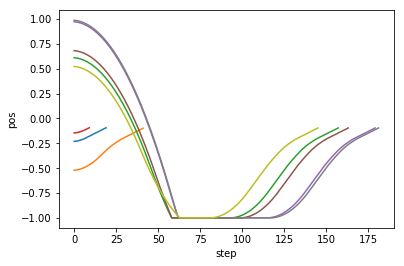

In [3]:
import rl.callbacks
class EpisodeLogger(rl.callbacks.Callback):
    def __init__(self):
        self.observations = {}
        self.rewards = {}
        self.actions = {}

    def on_episode_begin(self, episode, logs):
        self.observations[episode] = []
        self.rewards[episode] = []
        self.actions[episode] = []

    def on_step_end(self, step, logs):
        episode = logs['episode']
        self.observations[episode].append(logs['observation'])
        self.rewards[episode].append(logs['reward'])
        self.actions[episode].append(logs['action'])

cb_ep = EpisodeLogger()
dqn.test(env, nb_episodes=10, visualize=False, callbacks=[cb_ep])


%matplotlib inline
import matplotlib.pyplot as plt

for obs in cb_ep.observations.values():
    plt.plot([o[0] for o in obs])
plt.xlabel("step")
plt.ylabel("pos")